# Deep Learning and Image Recognition

## IMDB Text Classification

Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

- Dataset: https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification
- Source: https://keras.io/examples/imdb_fasttext/

In [13]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D
from keras.datasets import imdb

In [2]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.

    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}

    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.

    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]

    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences


In [3]:
# Set parameters:
# ngram_range = 2 will add bi-grams features

ngram_range = 2
max_features = 20000
maxlen = 400
batch_size = 32
embedding_dims = 50
epochs = 5

## Read Data

In [4]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Average train sequence length: {}'.format(
    np.mean(list(map(len, x_train)), dtype=int)))
print('Average test sequence length: {}'.format(
    np.mean(list(map(len, x_test)), dtype=int)))

if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    x_test = add_ngram(x_test, token_indice, ngram_range)
    print('Average train sequence length: {}'.format(
        np.mean(list(map(len, x_train)), dtype=int)))
    print('Average test sequence length: {}'.format(
        np.mean(list(map(len, x_test)), dtype=int)))

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Average train sequence length: 238
Average test sequence length: 230
Adding 2-gram features
Average train sequence length: 476
Average test sequence length: 428
Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)


In [5]:
X = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# summarize size
print("Training data: ")
print(X.shape)
print(y.shape)

# Summarize number of classes
print("Classes: ")
print(np.unique(y))

# Summarize number of classes
print("Number of words: ")
print(len(np.unique(np.hstack(X))))

Training data: 
(50000, 400)
(50000,)
Classes: 
[0 1]
Number of words: 
1120132


In [6]:
# Summarize review length
print("Review length: ")
result = [len(x) for x in X]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))

Review length: 
Mean 400.00 words (0.000000)


## Build model 

In [7]:
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 50)           60261500  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 60,261,551
Trainable params: 60,261,551
Non-trainable params: 0
_________________________________________________________________


In [8]:
#compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
#plot loss curve
def plot_loss(history):
    plt.figure(figsize=[8,6])
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)

In [10]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))


Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 51s 2ms/step - loss: 0.5868 - accuracy: 0.7718 - val_loss: 0.4385 - val_accuracy: 0.8572
Epoch 2/5
25000/25000 [==============================] - 51s 2ms/step - loss: 0.2888 - accuracy: 0.9270 - val_loss: 0.3034 - val_accuracy: 0.8922
Epoch 3/5
25000/25000 [==============================] - 51s 2ms/step - loss: 0.1444 - accuracy: 0.9689 - val_loss: 0.2614 - val_accuracy: 0.9000
Epoch 4/5
25000/25000 [==============================] - 61s 2ms/step - loss: 0.0780 - accuracy: 0.9874 - val_loss: 0.2439 - val_accuracy: 0.9040
Epoch 5/5
25000/25000 [==============================] - 50s 2ms/step - loss: 0.0443 - accuracy: 0.9945 - val_loss: 0.2371 - val_accuracy: 0.9051


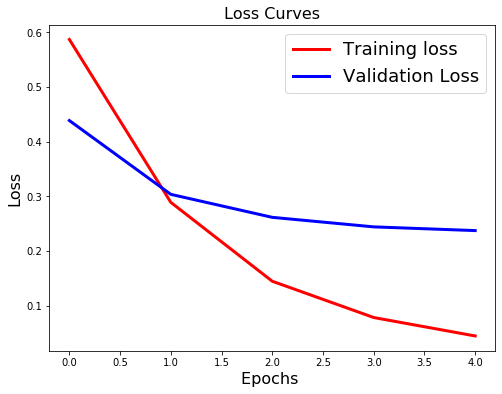

In [11]:
plot_loss(history)

In [12]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 56us/step


[0.23710881604671477, 0.9050800204277039]